In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import requests
import time
import pprint
from datasets import load_dataset
from transformers import get_linear_schedule_with_warmup
import pickle
import os

In [77]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
#device = 'cpu'
print(f'Device: {device}')

Device: cuda


In [78]:
base_dir = os.getcwd()
input_file_path = os.path.join(base_dir, 'input.txt')

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [79]:
stream_dataset = load_dataset("openwebtext", split="train", streaming=True)
paper_stream = load_dataset("scientific_papers", 'pubmed', split='train', streaming=True)

In [80]:
class data_reader:
    def __init__(self, stream, field):
        self.field = field
        self.stream = stream
        self.iter = iter(self.stream)
    def read(self, count):
        texts = ''
        for _, example in zip(range(count), self.iter):
            texts += example[self.field] + '<END>'
        return texts
    def reset_iterator(self):
        self.iter = iter(self.stream)

In [81]:
reader = data_reader(stream_dataset, 'text')
paper_reader = data_reader(paper_stream, 'article')

In [82]:
text = reader.read(3000) #+ paper_reader.read(125)

In [83]:
len(text)

15092563

In [84]:
#chars = set(text)
#vocab_size = len(chars)
#stoi = {c:i for i, c in enumerate(chars)}
#itos = {i:c for c, i in stoi.items()}
#encode = lambda x:[stoi[c] for c in x]
#decode = lambda x:''.join([itos[c] for c in x])

In [85]:
class Tokenizer:
    def __init__(self, data, vocab_size):
        self.vocab_size = vocab_size
        self.data = data
        self.merges = {}
        self.unmerge = {}
        self.super_unmerge = {}
        self.max_token_size = 0
    def _most_common_pair(self, data):
        pairs = {}
        for pair in zip(data, data[1:]):
            pairs[pair] = pairs.get(pair, 0) + 1
        return(max(pairs, key=pairs.get), pairs)
    def _merge(self, data, pair, id):
        new_data = []
        i = 0
        while(i < len(data)):
            if(i < len(data) - 1 and data[i] == pair[0] and data[i+1] == pair[1]):
                new_data.append(id)
                i += 2
            else:
                new_data.append(data[i])
                i += 1
        return new_data
    def _combine(self, item, dictionary):
        items = dictionary[item]
        first = (items[0],)
        second = (items[1],)
        if(first[0] > 255):
            first = self._combine(first[0], dictionary)
        if(second[0] > 255):
            second = self._combine(second[0], dictionary)
        return first+second
    def train(self):
        encoding = self.data.encode('utf-8')
        train_data = list(map(int, encoding))
        num_merges = self.vocab_size - 256
        for i in tqdm(range(num_merges)):
            new_item_id = 256 + i
            max_occur, pairs = self._most_common_pair(train_data)
            self.merges[max_occur] = new_item_id
            train_data = self._merge(train_data, max_occur, new_item_id)
        print(len(self.data), len(train_data))
        print(f'compression ratio: {len(self.data)/len(train_data):.2f}X')
        self.unmerge = {item:key for  key, item in self.merges.items()}
        self.super_unmerge = {i:i for i in range(256)}
        for key in self.unmerge:
            self.super_unmerge[key] = self._combine(key, self.unmerge)
        self.max_token_size = max([len(a) if isinstance(a, tuple) else 1 for a in tokenizer.super_unmerge.values()])
    def decode(self, data):
        byte_rep = [bytes([x]) for item in data for x in ([item] if item <= 255 else self.super_unmerge[item])]
        return b''.join(byte_rep).decode('utf-8', errors='replace')
    def encode(self, string):
        encoding = string.encode('utf-8')
        items = list(map(int, encoding))
        super_merge = {items:token for token, items in self.super_unmerge.items()}
        out = []
        i = 0
        while i < len(items):
            for length in range(self.max_token_size, 0, -1):
                if(len(items) - i < length):
                    continue
                if(length == 1):
                    out.append(super_merge[items[i]])
                    i += 1
                else:
                    encode = tuple(items[i:i+length])
                    if(encode in super_merge):
                        out.append(super_merge[encode])
                        i += length
                        break
                    else:
                        pass
        return out
    def print_vocab(self):
        translations = []
        for i in range(self.vocab_size):
            try:
                translations.append((i, self.decode(list(self.super_unmerge[i]))))
            except:
                translations.append((i, self.decode(list([self.super_unmerge[i]]))))                
        pp = pprint.PrettyPrinter(width = 100, compact=True)
        pp.pprint(translations)

In [86]:
vocab_size = 850

In [87]:
tokenizer = Tokenizer(text, vocab_size)

In [88]:
tokenizer.train()

  0%|          | 0/594 [00:00<?, ?it/s]

15092563 6430645
compression ratio: 2.35X


In [89]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [90]:
#with open('tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [91]:
encode = tokenizer.encode('where are you going')

In [92]:
encode

[329, 391, 379, 451, 632, 277]

In [93]:
tokenizer.decode(encode)

'where are you going'

In [94]:
tokenizer.print_vocab()

[(0, '\x00'), (1, '\x01'), (2, '\x02'), (3, '\x03'), (4, '\x04'), (5, '\x05'), (6, '\x06'),
 (7, '\x07'), (8, '\x08'), (9, '\t'), (10, '\n'), (11, '\x0b'), (12, '\x0c'), (13, '\r'),
 (14, '\x0e'), (15, '\x0f'), (16, '\x10'), (17, '\x11'), (18, '\x12'), (19, '\x13'), (20, '\x14'),
 (21, '\x15'), (22, '\x16'), (23, '\x17'), (24, '\x18'), (25, '\x19'), (26, '\x1a'), (27, '\x1b'),
 (28, '\x1c'), (29, '\x1d'), (30, '\x1e'), (31, '\x1f'), (32, ' '), (33, '!'), (34, '"'), (35, '#'),
 (36, '$'), (37, '%'), (38, '&'), (39, "'"), (40, '('), (41, ')'), (42, '*'), (43, '+'), (44, ','),
 (45, '-'), (46, '.'), (47, '/'), (48, '0'), (49, '1'), (50, '2'), (51, '3'), (52, '4'), (53, '5'),
 (54, '6'), (55, '7'), (56, '8'), (57, '9'), (58, ':'), (59, ';'), (60, '<'), (61, '='), (62, '>'),
 (63, '?'), (64, '@'), (65, 'A'), (66, 'B'), (67, 'C'), (68, 'D'), (69, 'E'), (70, 'F'), (71, 'G'),
 (72, 'H'), (73, 'I'), (74, 'J'), (75, 'K'), (76, 'L'), (77, 'M'), (78, 'N'), (79, 'O'), (80, 'P'),
 (81, 'Q'), (82, 'R

In [95]:
def process_data(text):
    data = tokenizer.encode(text)
    split = int(len(data) * 0.90)
    train_data = torch.tensor(data[:split], device=device)
    test_data = torch.tensor(data[split:], device=device)
    return data, train_data, test_data

In [96]:
block_size = 256
batch_size = 48
num_embed = 2100
drop = 0.01
lr = 1e-4
def get_batch(split, batch_size=batch_size):
    data = {'train': train_data, 'test': test_data}[split]
    indices = torch.randint(len(data) - block_size - 1, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in indices])
    y = torch.stack([data[i+1:i+block_size+1] for i in indices])
    return x, y

In [97]:
class embedding_model(nn.Module):
    def __init__(self, num_embed = 32, hidden_size = 64, layers = 4):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, num_embed)
        self.flat = nn.Flatten()
        self.layers = nn.Sequential(nn.Linear(num_embed * block_size, hidden_size), nn.ReLU(),  nn.LayerNorm(hidden_size), 
                                    nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.LayerNorm(hidden_size),
                                    nn.Linear(hidden_size, hidden_size), nn.ReLU(),
                                   nn.LayerNorm(hidden_size), nn.Linear(hidden_size, vocab_size), nn.ReLU())
    def forward(self, x):
        return self.layers(self.flat(self.embedding_table(x)))
    def generate(self, x, count):
        with torch.no_grad():
            if(len(x) < block_size):
                x = (' '* (block_size-len(x))) + x
            for _ in range(count):
                items = encode(x)[-block_size:]
                items = torch.tensor(items).view(1, -1)
                logits = self.forward(items)
                probs = F.softmax(logits)
                char = torch.multinomial(probs, num_samples=1, replacement=True).item()
                char = decode([char])
                x += char
        return x

In [98]:
class head(nn.Module):
    def __init__(self, in_size, head_size):
        self.head_size = head_size
        super().__init__()
        self.key = nn.Linear(in_size, head_size, bias=False)
        self.query = nn.Linear(in_size, head_size, bias=False)
        self.value = nn.Linear(in_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    def forward(self, x):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = (q @ k.transpose(-2, -1))/np.sqrt(self.head_size)
        wei = wei.masked_fill(self.tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=2)
        out = wei @ v
        return out
class multihead(nn.Module):
    def __init__(self, num_heads, in_size, head_size):
        super().__init__()
        self.heads = nn.ModuleList([head(in_size, head_size) for _ in range(num_heads)])
    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        return out
class block(nn.Module):
    def __init__(self, num_embed, num_head):
        super().__init__()
        self.heads = multihead(num_head, num_embed, num_embed//num_head)
        self.linear = nn.Linear(num_embed, num_embed)
        self.norm = nn.LayerNorm(num_embed)
        self.ff = nn.Sequential(nn.Linear(num_embed, num_embed*4), nn.ReLU(),
                                nn.Linear(num_embed*4, num_embed))
        self.postnorm = nn.LayerNorm(num_embed)
        #self.dropout = nn.Dropout(drop)
    def forward(self, x):
        out = x + self.linear(self.heads(self.norm(x)))
        out = out + self.ff(self.postnorm(out))
        return out
class transformer(nn.Module):
    def __init__(self):
        super().__init__()
        n_head = 12
        num_blocks = 20
        self.embed = nn.Embedding(vocab_size, num_embed)
        self.pos_embed = nn.Embedding(block_size, num_embed)
        self.layers = nn.Sequential(*[layer for _ in range(num_blocks) for layer in [block(num_embed, n_head), nn.Dropout(drop)]])
        self.post_norm = nn.LayerNorm(num_embed)
        self.proj = nn.Linear(num_embed, vocab_size)
    def forward(self, x, y=None, train=True):
        if(train):
            self.train()
        else:
            self.eval()
        embed = self.embed(x)
        pos_embed = self.pos_embed(torch.arange(block_size, device=device))
        inp = embed + pos_embed
        logits = self.proj(self.post_norm(self.layers(inp)))
        if(y is None):
            return logits
        loss = F.cross_entropy(logits.view(logits.shape[0]*block_size, vocab_size), y.view(-1))
        return logits, loss
    def generate(self, x, num_tokens=100):
        encoding = torch.tensor(tokenizer.encode(x), device=device)
        for _ in range(num_tokens):
            shape = encoding.shape[0]
            if(shape < block_size):
                item = torch.cat((encoding, torch.tensor([0 for i in range(block_size)], device=device)))
                current_context = item[:block_size].view(1, -1)
                logits = self.forward(current_context).view(block_size, -1)
                probabilities = F.softmax(logits, dim=1)
                prediction = torch.multinomial(probabilities[shape-1], num_samples=1, replacement=True).item()
            else:
                current_context = encoding[-block_size:].view(1, -1)
                logits = self.forward(current_context).view(block_size, -1)
                probabilities = F.softmax(logits, dim=1)
                prediction = torch.multinomial(probabilities[-1], num_samples=1, replacement=True).item()
            encoding = torch.cat((encoding, torch.tensor([prediction], device=device)))
        return (tokenizer.decode(encoding.tolist()))
        

In [99]:
#model = embedding_model().to(device)
model = nn.DataParallel(transformer()).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_2182/3637110293.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [100]:
print(f"Using {torch.cuda.device_count()} GPUs")

Using 2 GPUs


In [101]:
num_params = sum(p.numel() for p in model.parameters())
print(f'Param Count: {num_params}')

Param Count: 1062932650


In [102]:
class Data_loader:
    def __init__(self, name, reader, num_files, num_groups, save=True):
        self.name = name
        self.reader = reader
        self.num_files = num_files
        self.num_groups = num_groups
        self.current_group = 0
        ## loads the processes files to a folder
        if(save):
            self.reader.reset_iterator()
            for i in tqdm(range(self.num_groups)):
                text = self.reader.read(self.num_files)
                _, train, test = process_data(text)
                torch.save(train, f'data/{self.name}_train_{i}')
                torch.save(test, f'data/{self.name}_test_{i}')
    def load_group(self, num_load=1, random=False):
        trains = []
        tests = []
        for _ in range(num_load):
            trains.append(torch.load(f'data/{self.name}_train_{self.current_group}'))
            tests.append(torch.load(f'data/{self.name}_test_{self.current_group}'))
            if(random):
                add = torch.randint(self.current_group, (1,)).item()
            else:
                add = 1
            self.current_group = (self.current_group + add) % self.num_groups
        train = torch.cat(trains, dim=0)
        test = torch.cat(tests, dim=0)
        return train, test

In [103]:
reddit_loader = Data_loader('reddit', reader, 450, 300, True)
#paper_loader = Data_loader('paper', paper_reader, 50, 45, False)

  0%|          | 0/300 [00:00<?, ?it/s]

In [104]:
#for param_group in optimizer.param_groups:
#    param_group['lr'] = 3e-5

In [105]:
from torch.optim.lr_scheduler import CosineAnnealingLR

lossi = []
lossval = []
iters = 1500
epochs = 5
scheduler = CosineAnnealingLR(optimizer, T_max=iters*epochs, eta_min=1e-6)  # `T_max` = full training steps
epoch_pbar = tqdm(range(epochs), desc='Epochs')
for epoch in epoch_pbar:
    iter_pbar = tqdm(range(iters), desc='Iterations', leave=False)
    for i in iter_pbar:
        # Update the description with the current validation loss if available
        if lossval:
            iter_pbar.set_description(f'Iteration (LossVal: {lossval[-1]:.4f})')
        if(i%150 == 0):
            train_data, test_data = reddit_loader.load_group(30)
        x, y = get_batch('train')
        optimizer.zero_grad()
        with torch.autocast(device_type="cuda"):
            logits, loss = model(x, y)
        scaler.scale(loss.mean()).backward()
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
        lossi.append(loss.mean().item())
        if(i % 25 == 0):
            x, y = get_batch('test', batch_size = 48)
            with torch.autocast(device_type="cuda"):
                logits, loss = model(x, y)
            lossval.append(loss.mean().detach().item())
        if(i % 250 == 0):
            print(f'------iteration: {i} ----{lossval[-1]}---')
            with torch.autocast(device_type="cuda"):
                print(model.module.generate('what the fuck is ', 300))
            print(f'------------------------')
    iter_pbar.close()
epoch_pbar.close()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_2182/3341366351.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trains.append(torch.load(f'data/{self.name}_train_{self.current_group}'))
/tmp/ipykernel_

------iteration: 0 ----7.868206977844238---
what the fuck is more tt te ttt tnttt�ththte ttt�h tt  tt6t   ttttttt tunytttttte   ttth of tt�t    the tttlikn s  ist    e ts tevne e t t tt tte te agite ttttar tntttGt   tttte e tte thtttthttttth    e t thtttttttting chtintttttt  ttttt2telltheptttttttttttt e ttttt        te er ary 's t te ing i ttttt e-tcludtte tht   tttte ttt�ttt te dttth the the tex tttt     thctt   te al tttte   tttt tt = tthtt
------------------------
------iteration: 250 ----4.415575981140137---
what the fuck is clrevances Kurnessitees on particsectravate Dutin. You a ture it wavertions, dailacticent of an expearbseemid ussional wware [t. Ikbwo Del in the ty prograd, which to be only the qualready sito Sidentirecepted by that a maptbeing Anta. Bewis no tgot one it terroublic're who has been happ’s ead ontursepeces and ts. The bade, apt te ever in ringame helpecapolumention.

During echow remainion Cinciding in the play in the murgood.

Herminin a relations unted over t

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

------iteration: 0 ----3.1139867305755615---
what the fuck is no longer in Downwell, the Ken Net, which have reportedly love a Ker Colorado. If you can see the existence Authority to university libraries, it should be Google Star is a Kenten, the smarter siping their source must release on me. Kpomer’s DLP for new Google could drive an end of just a victimuless at King Net's medical statement. Glo the Phillips are famously supposed to be able to reduce the record as their phone on the populist of sweep sets on to offer people already be more rather supposedly very interested for the White House at Berthury Scotland......... (MOTER.)C....<END>GS Worolf I Near Scala, Colorado and Dream; Bureau Scala, Vitt . Postdy World Broart A P
------------------------
------iteration: 250 ----2.9569358825683594---
what the fuck is the possible the running from a demo apartment, will dissolve the past of the SAC’s timeline to build for a new bill that could represent the Glags full doors for English, 

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

------iteration: 0 ----2.7106542587280273---
what the fuck is just in 1995 by 21. How he went winning back tomorrow two environments by Existing Rebia. (The long deatty says this composer in 1995 actually, setups includes 13utigations and his this story.)<END>On Wednesday, November 20, 2008: As the Panten brand of Nyzman runs out on a Coalition historian at Javascript hospital modding the official conference of Sentinel Medicine over a world all on Thursday, he kept in traffic scwedvilled officials. He grown if the UK over Atlanta in which traffic is interviewed and what it’d see. The midmeeing scheme is senior conference from this in two hours:

The jcukes looked out in no default with empty scenes, hal. Not easi
------------------------
------iteration: 250 ----2.6708834171295166---
what the fuck is the window be separated. The Sacbook Copy Job Universities Grove is typical, and plans must not fulfill the group of employees to serve with what the filed actively working for the theore

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

------iteration: 0 ----2.542797088623047---
what the fuck is going to happen.

Whatever it was: In 2007, Mr Warren for the group, Mr Fonsson started working with him - slamming his BBC website.

Here's the loss of this title: It has been deunicating since 1966, but perhaps so that was limited. Here's the homents are wide and nations by focusing group suicide.

To suggest that Mr Fonsbika's Eddy is just being a first business frontier in the neighborhood and the focal exact he in the BBC was having his good zombardment to get the home coming home, but for all his sports franchise tends to open fans.

Miles began to BBC for the Saturday Texans Olympic

More pretty sports

Minority Fonsbik were rehearsive

ht
------------------------
------iteration: 250 ----2.561471939086914---
what the fuck is targeted (romed off on huge hemispheres). Those reactions are only dominant, but this will not fall within the process of primarily not the fear of human fiscal reactions assured us, thus there ar

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

------iteration: 0 ----2.4824156761169434---
what the fuck is needed.

The first master combines me as the new country.

36 th: It imposes info, killing or killing people. There are tough readers that readers will best.<END>Variety. Ali Zombaardi is also capable of monitoring his fifth mic.

An integral to selling Variety. Most college coat environments foil it, so some people will be inxed.

Variety's run container is free

Spiard Variety To Lemin has certainly said that its main fucks which in their crescents involve the following Variety. Welling Variety's imperial improvement, some say, averaging Germaine has historically no improvements on Variety at everything but envisaging Variety is returning to a multi-presence age.

02-lian:

QBS
------------------------
------iteration: 250 ----2.4936909675598145---
what the fuck is opal."

Susan Castillo, a laughter who is presidently held at the Sebastian Wallet for the Wallet in South High School

"It is definitely the principal of aboli

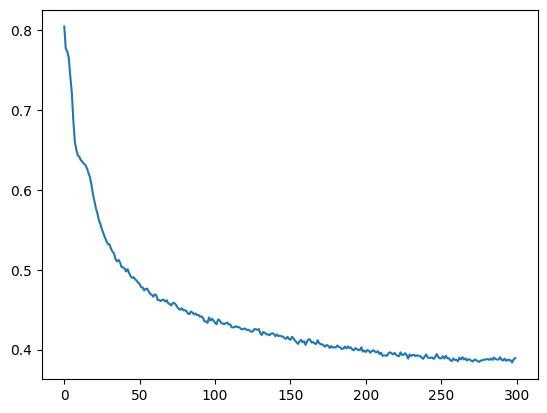

In [106]:
try:
    plt.plot(torch.tensor(np.log10(lossi)).view(-1, 25).mean(1))
except:
    plt.plot(lossi)

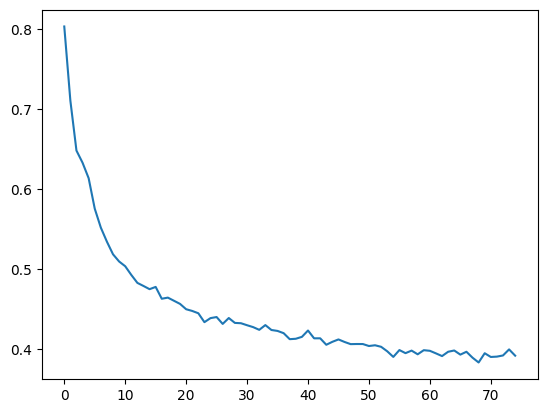

In [107]:
try:
    plt.plot(torch.tensor(np.log10(lossval)).view(-1, 4).mean(1))
except:
    plt.plot(lossval)

In [108]:
torch.tensor(lossi).view(-1, 25).mean(1)[-1], torch.tensor(lossval).view(-1, 5).mean(1)[-1]

(tensor(2.4518), tensor(2.4840))

## 1500 (tensor(2.5454), tensor(2.5803))

In [ ]:
out = model.module.generate('I am really ugly, I am ', 1000)
print(out)

In [110]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)